In [143]:
def normalize(df):
    df = df.to_numpy()
    arr = df.transpose()
    new = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        new[i,:] = (arr[i,:] - np.mean(arr[i,:])) / np.std(arr[i,:])
    new_transpose = new.transpose()
    res = pd.DataFrame(data=new_transpose)
    return res

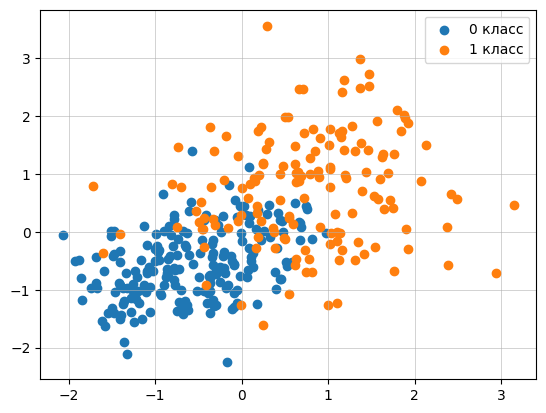

In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


df1 = pd.read_csv('data_lab3/data_lab3v02.csv', names=[1,2,'y'])
df = normalize(df1[[1,2]])
df1['y'].replace(-1, 0, inplace=True)
plt.scatter(df[0].loc[df1['y'] == 0], df[1].loc[df1['y'] == 0], label='0 класс')
plt.scatter(df[0].loc[df1['y'] == 1], df[1].loc[df1['y'] == 1], label='1 класс')
plt.legend()
plt.grid(True, linewidth=0.4)

In [145]:
print(len(df1), 'Объем выборки')
print(len(df1.loc[df1['y'] == 0]), 'Количество 0 класса')
print(len(df1.loc[df1['y'] == 1]), 'Количество 1 класса')

350 Объем выборки
200 Количество 0 класса
150 Количество 1 класса


In [146]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        # Define a single linear layer
        self.linear1 = nn.Linear(2, 30)
        self.linear2 = nn.Linear(30, 5)
        self.linear3 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = nn.Sigmoid()(x)
        x = self.linear2(x)
        x = nn.Tanh()(x)
        x = self.linear3(x)
        return torch.sigmoid(x)  # Apply sigmoid activation function for binary classification

# Initialize the model
model = LinearClassifier()

# Print the model structure
print(model)

LinearClassifier(
  (linear1): Linear(in_features=2, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=5, bias=True)
  (linear3): Linear(in_features=5, out_features=1, bias=True)
)


In [148]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df1[[1,2]], df1['y'], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
print(len(X_train), 'Объем тренировочной выборки')
print(len(X_test), 'Объем тестовой выборки')
print(len(X_val), 'Объем валидационной выборки')
print(f'0: {len(y_train[y_train == 0])}, 1: {len(y_train[y_train == 1])} в тренировочной')
print(f'0: {len(y_val[y_val == 0])}, 1: {len(y_val[y_val == 1])} в валидационной')
print(f'0: {len(y_test[y_test == 0])}, 1: {len(y_test[y_test == 1])} в тестовой')

210 Объем тренировочной выборки
35 Объем тестовой выборки
105 Объем валидационной выборки
0: 118, 1: 92 в тренировочной
0: 61, 1: 44 в валидационной
0: 21, 1: 14 в тестовой


In [149]:
X = torch.tensor(X_train.to_numpy(), dtype = torch.float)
y = torch.reshape(torch.tensor(np.array(y_train), dtype = torch.float), (len(y_train), 1))
X_val = torch.tensor(X_val.to_numpy(), dtype = torch.float)
y_val = torch.reshape(torch.tensor(np.array(y_val), dtype = torch.float), (len(y_val), 1))
X_test = torch.tensor(X_test.to_numpy(), dtype = torch.float)
y_test = torch.reshape(torch.tensor(np.array(y_test), dtype = torch.float), (len(y_test), 1))

In [150]:
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_losses = []
train_acc = []
val_losses = []
val_acc = []
test_losses = []
test_acc = []

num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X)
    # Compute loss
    loss = criterion(y_pred, y)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        train_outputs = model(X)
        train_loss = criterion(train_outputs, y)
        train_losses.append(train_loss.item())
        train_acc.append(accuracy_score(y.numpy(), (train_outputs.squeeze() > 0.5).numpy()))
        
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
        val_acc.append(accuracy_score(y_val.numpy(), (val_outputs.squeeze() > 0.5).numpy()))
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
        test_acc.append(accuracy_score(y_test.numpy(), (test_outputs.squeeze() > 0.5).numpy()))

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6638472676277161
Epoch 1000, Loss: 0.44166335463523865
Epoch 2000, Loss: 0.35271817445755005
Epoch 3000, Loss: 0.3286016583442688
Epoch 4000, Loss: 0.320138156414032
Epoch 5000, Loss: 0.31550514698028564
Epoch 6000, Loss: 0.3120008111000061
Epoch 7000, Loss: 0.3089311122894287
Epoch 8000, Loss: 0.3060033917427063
Epoch 9000, Loss: 0.30303600430488586


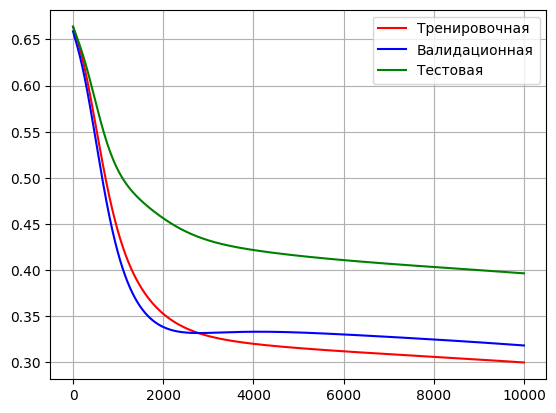

0.3460368106424809
0.3535925094395876
0.4376015225201845
0.8375576190476193
0.8436714285714286
0.7805085714285716


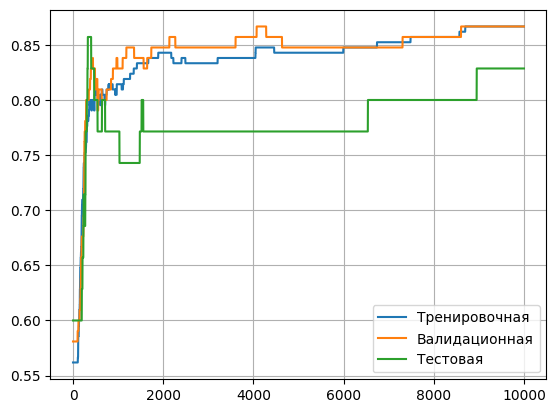

In [151]:
plt.plot(train_losses, color='r', label='Тренировочная')
plt.grid(True)
plt.plot(val_losses, color='b', label='Валидационная')
plt.grid(True)
plt.plot(test_losses, color='g', label='Тестовая')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(train_acc, label='Тренировочная')
plt.plot(val_acc, label='Валидационная')
plt.plot(test_acc, label='Тестовая')
plt.legend()
plt.grid(True)
print(np.mean(train_losses))
print(np.mean(val_losses))
print(np.mean(test_losses))
print(np.mean(train_acc))
print(np.mean(val_acc))
print(np.mean(test_acc))

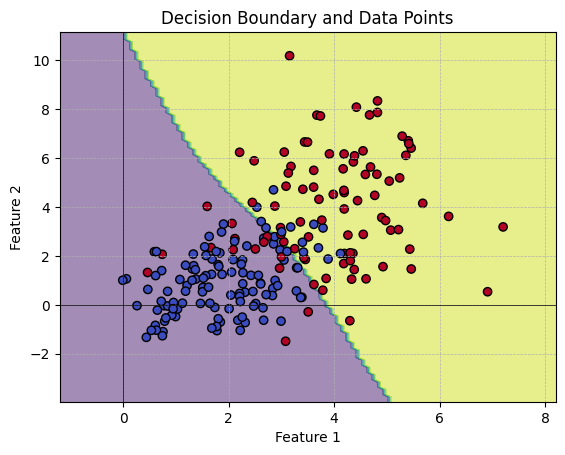

In [152]:
df1 = df1.to_numpy()
x_min, x_max = df1[:, 0].min() - 1, df1[:, 0].max() + 1
y_min, y_max = df1[:, 1].min() - 1, df1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

model.eval()  # Set the model to evaluation mode

# Predict classes for each point in the mesh grid
# Forward pass to get outputs. No need to track gradients here.
with torch.no_grad():
    Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = Z.reshape(xx.shape)
    Z = (Z > 0.5).float()  # Adjust the threshold as necessary

# Plot the contour and training examples
plt.contourf(xx, yy, Z, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary and Data Points')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='k', linewidth=0.5)  # Add x-axis
plt.axvline(x=0, color='k', linewidth=0.5)  # Add y-axis

plt.show()

In [153]:
def cls(prb):
    y_pred = np.copy(prb)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    return y_pred
def c_f(y_pred, y):
        TP = np.count_nonzero((y_pred == 1) & (y_pred == y))
        TN = np.count_nonzero((y_pred == 0) & (y_pred == y))
        FN = np.count_nonzero((y_pred == 0) & (y_pred != y))
        FP = np.count_nonzero((y_pred == 1) & (y_pred != y))
        return (TP, TN, FN, FP)

In [154]:
prob_test = model.forward(X_test).detach().numpy()[:,0]
y_pred_test = cls(prob_test)
TP_test, TN_test, FN_test, FP_test = c_f(y_pred_test, y_test.numpy()[:,0])
print(f'TP:{TP_test}  FN:{FN_test}')
print(f'FP:{FP_test}  TN:{TN_test}')

TP:12  FN:2
FP:4  TN:17


In [155]:
prob_train = model.forward(X).detach().numpy()[:,0]
y_pred_train = cls(prob_train)
TP_train, TN_train, FN_train, FP_train = c_f(y_pred_train, y.numpy()[:,0])
print(f'TP:{TP_train}  FN:{FN_train}')
print(f'FP:{FP_train}  TN:{TN_train}')

TP:76  FN:16
FP:12  TN:106


In [156]:
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_losses = []
train_acc = []
val_losses = []
val_acc = []
test_losses = []
test_acc = []

num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing X to the model
    y_pred = model(X)
    # Compute loss
    loss = criterion(y_pred, y)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        train_outputs = model(X)
        train_loss = criterion(train_outputs, y)
        train_losses.append(train_loss.item())
        train_acc.append(accuracy_score(y.numpy(), (train_outputs.squeeze() > 0.5).numpy()))
        
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
        val_acc.append(accuracy_score(y_val.numpy(), (val_outputs.squeeze() > 0.5).numpy()))
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())
        test_acc.append(accuracy_score(y_test.numpy(), (test_outputs.squeeze() > 0.5).numpy()))

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.299894779920578
Epoch 1000, Loss: 0.29648154973983765
Epoch 2000, Loss: 0.2927481234073639
Epoch 3000, Loss: 0.288724422454834
Epoch 4000, Loss: 0.28455084562301636
Epoch 5000, Loss: 0.2804727256298065
Epoch 6000, Loss: 0.2767607271671295
Epoch 7000, Loss: 0.27359282970428467
Epoch 8000, Loss: 0.271003782749176
Epoch 9000, Loss: 0.26892411708831787


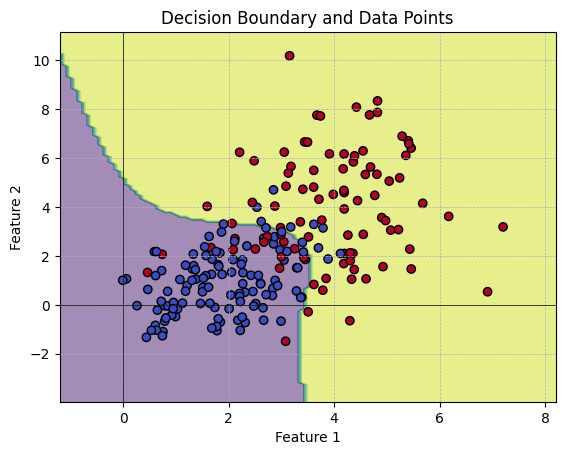

0.2816667202979326
0.29549775406718254
0.3788614309489727
0.8643852380952383
0.8698876190476195
0.8285714285714286


In [157]:
x_min, x_max = df1[:, 0].min() - 1, df1[:, 0].max() + 1
y_min, y_max = df1[:, 1].min() - 1, df1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

model.eval()  # Set the model to evaluation mode

# Predict classes for each point in the mesh grid
# Forward pass to get outputs. No need to track gradients here.
with torch.no_grad():
    Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = Z.reshape(xx.shape)
    Z = (Z > 0.5).float()  # Adjust the threshold as necessary

# Plot the contour and training examples
plt.contourf(xx, yy, Z, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary and Data Points')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='k', linewidth=0.5)  # Add x-axis
plt.axvline(x=0, color='k', linewidth=0.5)  # Add y-axis

plt.show()
print(np.mean(train_losses))
print(np.mean(val_losses))
print(np.mean(test_losses))
print(np.mean(train_acc))
print(np.mean(val_acc))
print(np.mean(test_acc))